In [2]:
from torchsummary import summary
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import time, os, random
import pickle
from my_utils.cosmo_loader import  kids450_files_cluster, regr_Kids450
from my_utils.cosmo_collate import cosmotrain_collate_fn
from torch.utils.data import Dataset, DataLoader
#from my_utils.models import Regression_model, Regression_model_2
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from scipy.spatial import ConvexHull
import matplotlib.animation as animation
#import IPython
#from IPython.display import HTML
#%matplotlib notebook

In [3]:
import sys
print(sys.path)

['/python', '', '/cluster/home/atepper/thesis_env_ubuntu/lib/python3.11/site-packages', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python311.zip', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/lib-dynload', '/cluster/home/atepper/mae_test_env/lib/python3.11/site-packages', '/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages']


In [4]:
from my_utils.real_resnets import Resnet_regressionmodel, Resnet_pretrainingmodel, DSModel
from my_utils.models import custom_pretrainingmodel, custom_DSModel, custom_Regression_model

In [5]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("GPU is available.")
else:
    device = torch.device("cpu")   # Use CPU
    print("GPU is not available, using CPU.")

GPU is available.


In [6]:
#Load dataloaders
file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 192
resolution = 128
train_data = regr_Kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
valid_data = regr_Kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
test_data =  regr_Kids450(phase = "test",file_paths = file_paths_test,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)
kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)
kids_test_loader = DataLoader(test_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)

print(f'Length of test data: {len(test_data)}')

Length of test data: 114000


/cluster/home/atepper/thesis_env_ubuntu/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/cl

In [7]:
#Load helperfunctions to inference the data
def get_model_checkpoints(run_name):
    """
    Function that returns all the available runs with different epochs with strings .pt
    args:
    """
    print(run_name)
    model_dir = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    run_name_w_prefix = run_name + "_epoch_"
    suffix = ".pt"
    
    all_files = os.listdir(model_dir)
    
    #get the matching files
    model_files = [f for f in all_files if f.startswith(run_name_w_prefix) and f.endswith(suffix)] 
    
    # Sort the files by epoch number if needed
    model_files.sort(key=lambda x: int(x[len(run_name_w_prefix):-len(suffix)]))
    
    return model_files
def get_truegrid():
    """
    Function that returns the truegrid of the predictionspace
    """
    
    truegrid_array = torch.empty((57,2))
    for i, file in tqdm(enumerate(file_paths_test), desc="Processing files"):
        with h5py.File(file, 'r') as file:
            
            #get the labels from the h5 file
            truegrid_array[i] = torch.tensor(file["labels"][0])
    return truegrid_array
#standardize
#get the statistics:
import pickle
def data_stats_dict():
    """
    Load data statistics for standardization
    """
    pickle_file_path = "/cluster/work/refregier/atepper/kids_450/full_data/kids450_test_stats.pkl"
    # Open the pickle file and load the data
    with open(pickle_file_path, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

  
def un_standardize(omega_m, sigma_8):
    """
    If needed get omega_m sigma_8 unstandardized
    """
    
    data_dict = data_stats_dict()
    mean_labels = data_dict["mean_labels"].numpy()
    std_dev_labels = data_dict["label_std_deviation"].numpy()
    
    
    omega_m = (omega_m * std_dev_labels[0]) + mean_labels[0]
    sigma_8 = (sigma_8 * std_dev_labels[1]) + mean_labels[1]
    
    return omega_m, sigma_8

def get_predictions(model, dataloader, device='cpu'):
    """
    Get predictions for all the predictable params
    """
    #set model to eval mode
    model.eval()
    true_values_omega_m = []
    true_values_sigma_8 = []
    pred_values_omega_m = []
    pred_values_sigma_8 = []
    with torch.no_grad():  # No need to compute gradients
        for i, (images,labels_true) in tqdm(enumerate(dataloader), desc="Processing data"):
            #print(i)
            images = images.squeeze().to(device).float()
            labels_true = labels_true.squeeze().to(device).float()
            labels_pred = model(images)
            
            pred_omega_m, pred_sigma_8 = labels_pred[:, 0], labels_pred[:, 1]
            true_omega_m, true_sigma_8 = labels_true[:, 0], labels_true[:, 1]
            
            true_values_omega_m.extend(true_omega_m.cpu().numpy())
            true_values_sigma_8.extend(true_sigma_8.cpu().numpy())
            pred_values_omega_m.extend(pred_omega_m.cpu().numpy())
            pred_values_sigma_8.extend(pred_sigma_8.cpu().numpy())
            #if i == 2:
            #    print("done")
            #    break
                
    return (np.array(true_values_omega_m), np.array(pred_values_omega_m)), \
           (np.array(true_values_sigma_8), np.array(pred_values_sigma_8))


#(true_omega_m, pred_omega_m), (true_sigma_8, pred_sigma_8) = get_predictions(model, kids_test_loader, device)

In [9]:
def load_checkpoint(model,run_path,run_name):
    """
    Load the model
    Returns:
    model : PreModel : model
    optimizer : torch.optim.Optimizer : optimizer
    scheduler : torch.optim.lr_scheduler : scheduler
    """
    #load_path = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    #run_name = "Kids_450_regrsimclr_full_test_epoch_100.pt"
    out = os.path.join(run_path ,run_name)
    checkpoint = torch.load(out)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [8]:
def run_inference(model, run_name,epochs):
    """
    
    Run inference for selected model
    
    """
    
    true_omega_m_list = []
    true_sigma_8_list = []
    pred_omega_m_list = []
    pred_sigma_8_list = []    
    #get model checkpoints
    model_checkpoints = get_model_checkpoints(run_name)
    run_path = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    #print(model_checkpoints)
    for i,run_name in enumerate(model_checkpoints):
        #if i == 15:
        #    break
        model = load_checkpoint(model, run_path ,run_name)
        
        #get predictions
        (true_omega_m, pred_omega_m), (true_sigma_8, pred_sigma_8) = get_predictions(model, kids_test_loader, device)
        #unstandardize the data
        unstd_pred_omega_m, unstd_pred_sigma_8 = un_standardize(pred_omega_m ,pred_sigma_8)
        
        true_omega_m_list.append(true_omega_m)
        pred_omega_m_list.append(unstd_pred_omega_m)
        true_sigma_8_list.append(true_sigma_8)
        pred_sigma_8_list.append(unstd_pred_sigma_8)
        
    return true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list

In [63]:
#the one with big Lr and nonlinear dropout
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_resnet_34_natural_images"
epochs = list(range(start_epoch,end_epoch+1))
model = Resnet_regressionmodel('resnet34',pretrained_weights = False,dropout_rate = 0.3,head_type = "nonlinear_dropout").to('cuda:0')
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Kids_450_resnet_34_natural_images


/scratch/tmp.7710050.atepper/ipykernel_1134287/3091983372.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(out)
/cluster/home/atepper/thesis_env_

In [16]:
#the one with snall Lr and nonlinear head
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_custom_dropout"
epochs = list(range(start_epoch,end_epoch+1))
#model = Resnet_regressionmodel('resnet34',pretrained_weights = False ,head_type = "nonlinear").to('cuda:0')
#model = Regression_model(layers = [3,4,6,3], head_type = "nonlinear" ,hidden_channels= 128).to("cuda")
model = custom_Regression_model("custom_resnet",layers = [3,4,6,3], dropout_rate = 0.3,head_type = "nonlinear_dropout" ,).to("cuda")
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Kids_450_custom_dropout


/scratch/tmp.6066674.atepper/ipykernel_1265928/3091983372.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(out)
Processing data: 593it [00:22, 25

In [23]:
#the one with smaller channels and 
start_epoch = 1
end_epoch = 150
run_name = "Kids_450_smaller_channels_dropout"
epochs = list(range(start_epoch,end_epoch+1))
model = Regression_model(layers = [3,4,6,3], head_type = "nonlinear_dropout" ,hidden_channels= 128).to("cuda")
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Processing data: 593it [00:30, 19.73it/s]
Processing data: 593it [00:29, 20.03it/s]
Processing data: 593it [00:29, 19.87it/s]
Processing data: 593it [00:29, 19.78it/s]
Processing data: 593it [00:31, 18.79it/s]
Processing data: 593it [00:30, 19.55it/s]
Processing data: 593it [00:30, 19.61it/s]
Processing data: 593it [00:30, 19.54it/s]
Processing data: 593it [00:30, 19.46it/s]
Processing data: 593it [00:30, 19.40it/s]
Processing data: 593it [00:30, 19.37it/s]
Processing data: 593it [00:30, 19.47it/s]
Processing data: 593it [00:30, 19.62it/s]
Processing data: 593it [00:30, 19.14it/s]
Processing data: 593it [00:30, 19.37it/s]
Processing data: 593it [00:30, 19.35it/s]
Processing data: 593it [00:30, 19.56it/s]
Processing data: 593it [00:30, 19.68it/s]
Processing data: 593it [00:30, 19.34it/s]
Processing data: 593it [00:30, 19.40it/s]
Processing data: 593it [00:30, 19.48it/s]


In [ ]:
start_epoch = 1
end_epoch = 150
epochs = list(range(start_epoch,end_epoch+1))
model = Regression_model(layers = [2,3,3,2,1,1], head_type= "nonlinear",hidden_channels= 64 ).to("cuda")
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

In [19]:
start_epoch = 1
end_epoch = 140
epochs = list(range(start_epoch,end_epoch+1))
model = Regression_model(layers = [2,3,3,2], head_type= "linear",hidden_channels= 256 ).to("cuda")
run_name = "Kids_450_new_build"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

Processing data: 593it [00:30, 19.62it/s]
Processing data: 593it [00:24, 24.59it/s]
Processing data: 593it [00:24, 24.51it/s]
Processing data: 593it [00:26, 22.59it/s]
Processing data: 593it [00:24, 23.94it/s]
Processing data: 593it [00:24, 24.17it/s]
Processing data: 593it [00:24, 23.81it/s]
Processing data: 593it [00:25, 22.89it/s]
Processing data: 593it [00:25, 23.54it/s]
Processing data: 593it [00:25, 23.31it/s]
Processing data: 593it [00:25, 23.09it/s]
Processing data: 593it [00:24, 23.98it/s]
Processing data: 593it [00:26, 22.51it/s]
Processing data: 593it [00:24, 24.11it/s]


In [57]:
#Create animation for the prediction ecolution trough time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    ax.clear()
    ax.set_xlim(0.05, 0.5)  # Adjust the limits according to your data
    ax.set_ylim(0.4, 1.4)  # Adjust the limits according to your data
    ax.set_title(f"Resnet Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel(r'$\Omega_m$',fontsize = 20)
    ax.set_ylabel(r'$\sigma_8$',fontsize = 20)
    #plt.xlabel(r'$\Omega_m$',fontsize = 20)
    #plt.ylabel(r'$\sigma_8$',fontsize = 20)

    
    # Plot scatter points for the current step
    sns.scatterplot(x=parameter1_data[frame], y=parameter2_data[frame], ax=ax)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="red", marker="o", s= 30)

        # Add text annotation for epoch
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + ".gif", writer='imagemagick')

# Display the animation
plt.show()

Processing files: 57it [00:02, 23.81it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


In [58]:
def start_stop(file_nr):
    """
    Get correct start stop intervals for 
    """
    file_nr -= 1 #due to starting index of pyth
    start = file_nr *2000
    end = start + 2000
    return start, end, file_nr

88000 90000


Processing files: 57it [00:00, 973.92it/s]


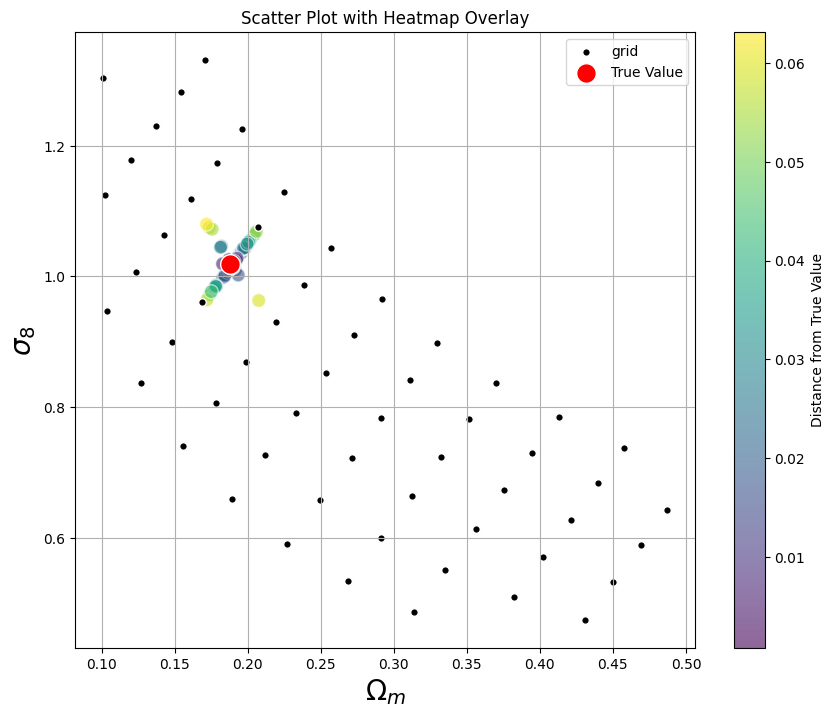

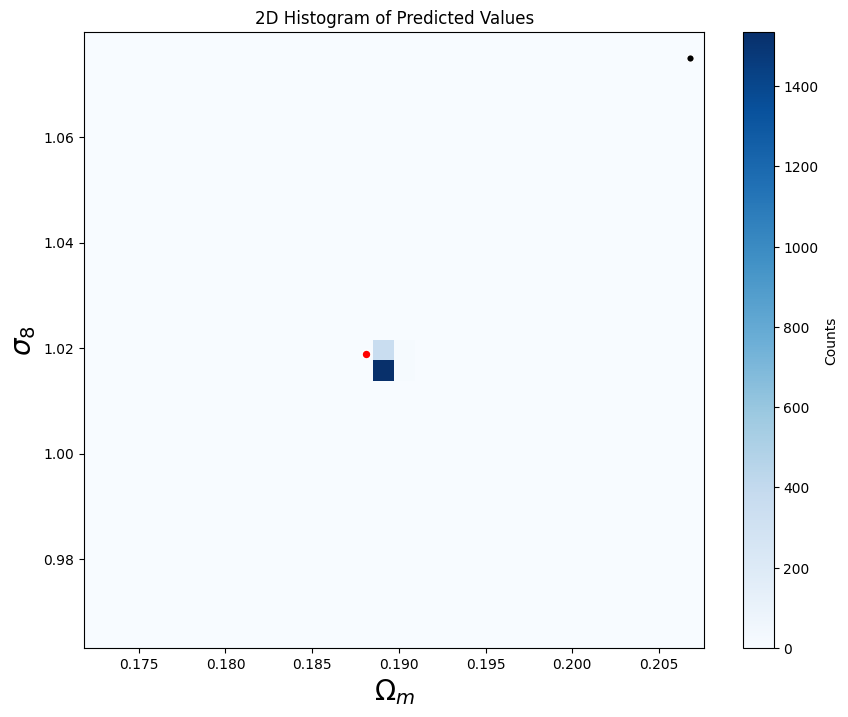

In [64]:
#in the test data every parameter is concurrent 2000 elements
epoch = 20
#start = 0
#stop = 2000
start, stop, file_index = start_stop(file_nr = 45)
print(start,stop)
pred_omega_m = pred_omega_m_list[epoch][start:stop]
pred_sigma_8 = pred_sigma_8_list[epoch][start:stop]
true_omega_m = true_omega_m_list[epoch][start:stop][0]
#print(true_omega_m_list[epoch])
true_sigma_8 = true_sigma_8_list[epoch][start:stop][0]

distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pred_omega_m, pred_sigma_8, c=distances, cmap='viridis', s=100, alpha=0.6, edgecolor='w')

# Add color bar to show the distance scale
cbar = plt.colorbar(scatter)
cbar.set_label('Distance from True Value')

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Plot the true value point
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=200, label='True Value', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 
#plt.xlim(0.05, 0.5)  # Adjust the limits according to your data
#plt.ylim(0.4, 1.4) 
plt.title('Scatter Plot with Heatmap Overlay')
plt.legend()
plt.grid(True)



# Show the plot
plt.show()

# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[30, 30], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')
#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

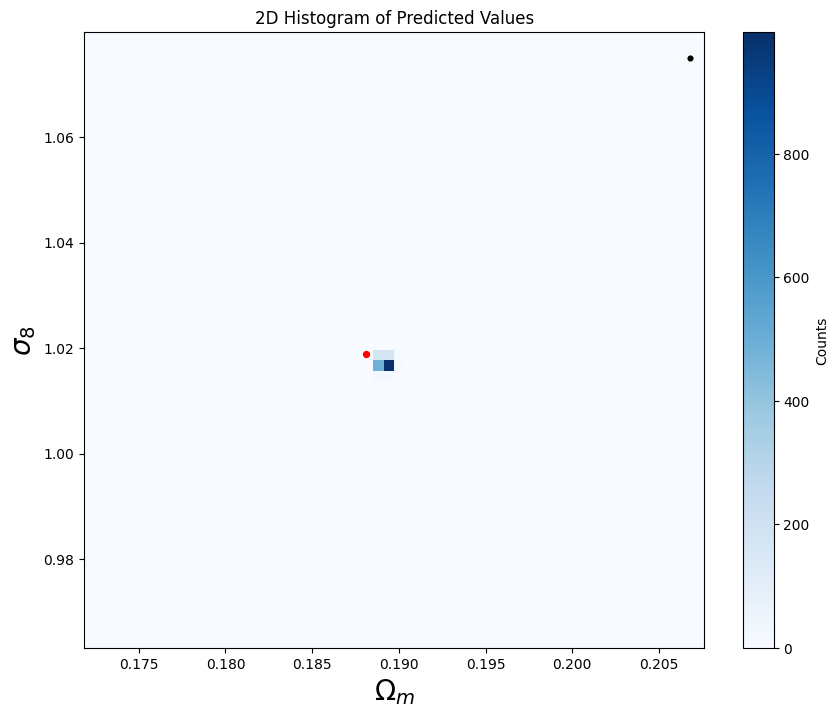

In [65]:
# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.cla()
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')

plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

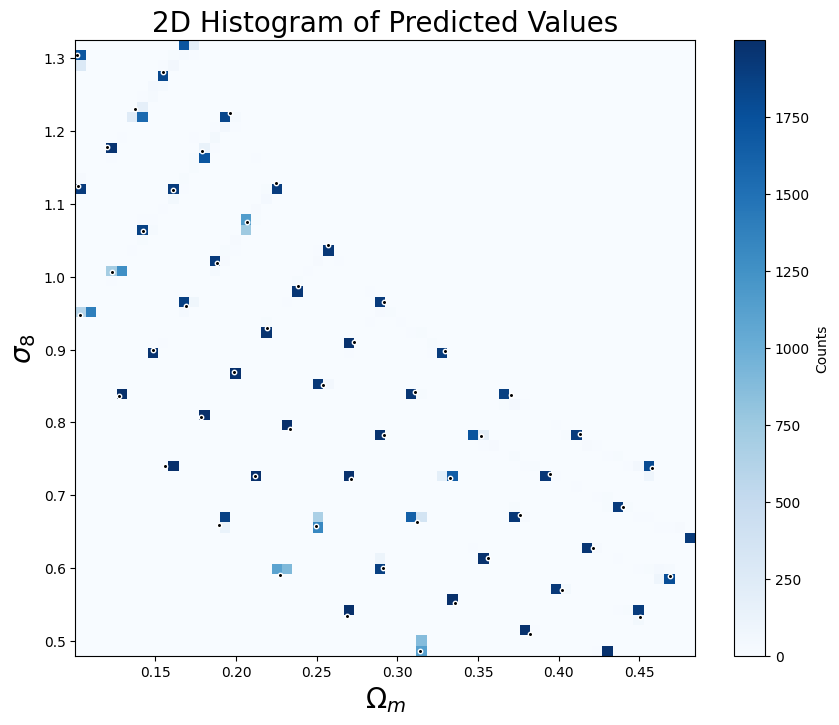

In [66]:
# Create 2D histogram
x = pred_omega_m_list[epoch]
y = pred_sigma_8_list[epoch]
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=10, label='grid', edgecolor='w')

# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)


plt.title('2D Histogram of Predicted Values',fontsize = 20)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name+"_paramsphist"

plt.savefig(save_path+'.pdf')

# Show plot
plt.show()

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


#in the test data every parameter is concurrent 2000 elements
#epoch = 1
pred_omega_m = pred_omega_m_list[epoch]
pred_sigma_8 = pred_sigma_8_list[epoch]


plt.figure(figsize=(10, 8))


truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Add color bar to show scale
plt.scatter(pred_omega_m, pred_sigma_8, c='blue', s=40, label='True Value', edgecolor='w')
plt.scatter(grid_omega_m, grid_sigma_8, c='red', s=30, label='grid', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('Predicted Values snapshot',fontsize = 20)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name+"_paramsp"

plt.savefig(save_path+'.pdf')
# Show plot
plt.show()

NameError: name 'pred_omega_m_list' is not defined

In [68]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
#in the test data every parameter is concurrent 2000 elements
start, stop, file_index = start_stop(file_nr = 8)
# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2
true_omega_m = true_omega_m_list[epoch][0]
true_sigma_8 = true_sigma_8_list[epoch][0]

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    pred_omega_m = parameter1_data[frame][start:stop]
    pred_sigma_8 = parameter2_data[frame][start:stop]
    true_omega_m = true_omega_m_list[frame][start:stop][0]
    true_sigma_8 = true_sigma_8_list[frame][start:stop][0]
    distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)
    
    #print(distances.shape)
    
    ax.clear()
    ax.set_xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
    ax.set_ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2)  # Adjust the limits according to your data
    ax.set_title(f"Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel('Omega_m')
    ax.set_ylabel('sigma_8')
    
    
    # Plot scatter points for the current step
    sns.scatterplot(x=pred_omega_m, y=pred_sigma_8, hue = distances ,ax=ax)
    #sns.heatmap(distances, ax=ax, cmap="viridis", cbar=True, alpha=0.6, annot=True)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="black", marker="o", s= 15)
    sns.scatterplot(x=true_omega_m_list[frame][start:stop], y=true_sigma_8_list[frame][start:stop] , ax=ax, color="red", marker="o", s= 30)
    
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.text(0.65, 0.95,f'True: omega_m: {true_omega_m:.2f}, sigma_8: {true_sigma_8:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')
plt.show()

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + "one_param_mse" + ".gif", writer='imagemagick')


Processing files: 57it [00:00, 952.81it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


The plots for downstram model with pretraining. I have to load the whole set. First the pretraining part, then infuse it with downstream and then i can load the checkpoints.


In [62]:
pretrained_model = Resnet_pretrainingmodel('resnet34_simclr',
                               pretrained_weights = False, #these are the resnet weights
                               dropout_rate = 0.2, 
                               head_type = "nonlinear").to('cuda:0')
model = DSModel(pretrained_model,
               base_model = "resnet34",
               dropout_rate = 0.2,
               head_type = "nonlinear_dropout").to('cuda:0')
#the one with big Lr and nonlinear dropout
start_epoch = 1
end_epoch = 15
run_name = "Kids_450_resnet_34_natural_images"
epochs = list(range(start_epoch,end_epoch+1))
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

/cluster/home/atepper/thesis_env_ubuntu/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/atepper/thesis_env_ubuntu/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Kids_450_resnet_34_natural_images


/scratch/tmp.7710050.atepper/ipykernel_1134287/3091983372.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(out)


RuntimeError: Error(s) in loading state_dict for DSModel:
	Missing key(s) in state_dict: "premodel.pretrained.conv1.weight", "premodel.pretrained.bn1.weight", "premodel.pretrained.bn1.bias", "premodel.pretrained.bn1.running_mean", "premodel.pretrained.bn1.running_var", "premodel.pretrained.layer1.0.conv1.weight", "premodel.pretrained.layer1.0.bn1.weight", "premodel.pretrained.layer1.0.bn1.bias", "premodel.pretrained.layer1.0.bn1.running_mean", "premodel.pretrained.layer1.0.bn1.running_var", "premodel.pretrained.layer1.0.conv2.weight", "premodel.pretrained.layer1.0.bn2.weight", "premodel.pretrained.layer1.0.bn2.bias", "premodel.pretrained.layer1.0.bn2.running_mean", "premodel.pretrained.layer1.0.bn2.running_var", "premodel.pretrained.layer1.1.conv1.weight", "premodel.pretrained.layer1.1.bn1.weight", "premodel.pretrained.layer1.1.bn1.bias", "premodel.pretrained.layer1.1.bn1.running_mean", "premodel.pretrained.layer1.1.bn1.running_var", "premodel.pretrained.layer1.1.conv2.weight", "premodel.pretrained.layer1.1.bn2.weight", "premodel.pretrained.layer1.1.bn2.bias", "premodel.pretrained.layer1.1.bn2.running_mean", "premodel.pretrained.layer1.1.bn2.running_var", "premodel.pretrained.layer1.2.conv1.weight", "premodel.pretrained.layer1.2.bn1.weight", "premodel.pretrained.layer1.2.bn1.bias", "premodel.pretrained.layer1.2.bn1.running_mean", "premodel.pretrained.layer1.2.bn1.running_var", "premodel.pretrained.layer1.2.conv2.weight", "premodel.pretrained.layer1.2.bn2.weight", "premodel.pretrained.layer1.2.bn2.bias", "premodel.pretrained.layer1.2.bn2.running_mean", "premodel.pretrained.layer1.2.bn2.running_var", "premodel.pretrained.layer2.0.conv1.weight", "premodel.pretrained.layer2.0.bn1.weight", "premodel.pretrained.layer2.0.bn1.bias", "premodel.pretrained.layer2.0.bn1.running_mean", "premodel.pretrained.layer2.0.bn1.running_var", "premodel.pretrained.layer2.0.conv2.weight", "premodel.pretrained.layer2.0.bn2.weight", "premodel.pretrained.layer2.0.bn2.bias", "premodel.pretrained.layer2.0.bn2.running_mean", "premodel.pretrained.layer2.0.bn2.running_var", "premodel.pretrained.layer2.0.downsample.0.weight", "premodel.pretrained.layer2.0.downsample.1.weight", "premodel.pretrained.layer2.0.downsample.1.bias", "premodel.pretrained.layer2.0.downsample.1.running_mean", "premodel.pretrained.layer2.0.downsample.1.running_var", "premodel.pretrained.layer2.1.conv1.weight", "premodel.pretrained.layer2.1.bn1.weight", "premodel.pretrained.layer2.1.bn1.bias", "premodel.pretrained.layer2.1.bn1.running_mean", "premodel.pretrained.layer2.1.bn1.running_var", "premodel.pretrained.layer2.1.conv2.weight", "premodel.pretrained.layer2.1.bn2.weight", "premodel.pretrained.layer2.1.bn2.bias", "premodel.pretrained.layer2.1.bn2.running_mean", "premodel.pretrained.layer2.1.bn2.running_var", "premodel.pretrained.layer2.2.conv1.weight", "premodel.pretrained.layer2.2.bn1.weight", "premodel.pretrained.layer2.2.bn1.bias", "premodel.pretrained.layer2.2.bn1.running_mean", "premodel.pretrained.layer2.2.bn1.running_var", "premodel.pretrained.layer2.2.conv2.weight", "premodel.pretrained.layer2.2.bn2.weight", "premodel.pretrained.layer2.2.bn2.bias", "premodel.pretrained.layer2.2.bn2.running_mean", "premodel.pretrained.layer2.2.bn2.running_var", "premodel.pretrained.layer2.3.conv1.weight", "premodel.pretrained.layer2.3.bn1.weight", "premodel.pretrained.layer2.3.bn1.bias", "premodel.pretrained.layer2.3.bn1.running_mean", "premodel.pretrained.layer2.3.bn1.running_var", "premodel.pretrained.layer2.3.conv2.weight", "premodel.pretrained.layer2.3.bn2.weight", "premodel.pretrained.layer2.3.bn2.bias", "premodel.pretrained.layer2.3.bn2.running_mean", "premodel.pretrained.layer2.3.bn2.running_var", "premodel.pretrained.layer3.0.conv1.weight", "premodel.pretrained.layer3.0.bn1.weight", "premodel.pretrained.layer3.0.bn1.bias", "premodel.pretrained.layer3.0.bn1.running_mean", "premodel.pretrained.layer3.0.bn1.running_var", "premodel.pretrained.layer3.0.conv2.weight", "premodel.pretrained.layer3.0.bn2.weight", "premodel.pretrained.layer3.0.bn2.bias", "premodel.pretrained.layer3.0.bn2.running_mean", "premodel.pretrained.layer3.0.bn2.running_var", "premodel.pretrained.layer3.0.downsample.0.weight", "premodel.pretrained.layer3.0.downsample.1.weight", "premodel.pretrained.layer3.0.downsample.1.bias", "premodel.pretrained.layer3.0.downsample.1.running_mean", "premodel.pretrained.layer3.0.downsample.1.running_var", "premodel.pretrained.layer3.1.conv1.weight", "premodel.pretrained.layer3.1.bn1.weight", "premodel.pretrained.layer3.1.bn1.bias", "premodel.pretrained.layer3.1.bn1.running_mean", "premodel.pretrained.layer3.1.bn1.running_var", "premodel.pretrained.layer3.1.conv2.weight", "premodel.pretrained.layer3.1.bn2.weight", "premodel.pretrained.layer3.1.bn2.bias", "premodel.pretrained.layer3.1.bn2.running_mean", "premodel.pretrained.layer3.1.bn2.running_var", "premodel.pretrained.layer3.2.conv1.weight", "premodel.pretrained.layer3.2.bn1.weight", "premodel.pretrained.layer3.2.bn1.bias", "premodel.pretrained.layer3.2.bn1.running_mean", "premodel.pretrained.layer3.2.bn1.running_var", "premodel.pretrained.layer3.2.conv2.weight", "premodel.pretrained.layer3.2.bn2.weight", "premodel.pretrained.layer3.2.bn2.bias", "premodel.pretrained.layer3.2.bn2.running_mean", "premodel.pretrained.layer3.2.bn2.running_var", "premodel.pretrained.layer3.3.conv1.weight", "premodel.pretrained.layer3.3.bn1.weight", "premodel.pretrained.layer3.3.bn1.bias", "premodel.pretrained.layer3.3.bn1.running_mean", "premodel.pretrained.layer3.3.bn1.running_var", "premodel.pretrained.layer3.3.conv2.weight", "premodel.pretrained.layer3.3.bn2.weight", "premodel.pretrained.layer3.3.bn2.bias", "premodel.pretrained.layer3.3.bn2.running_mean", "premodel.pretrained.layer3.3.bn2.running_var", "premodel.pretrained.layer3.4.conv1.weight", "premodel.pretrained.layer3.4.bn1.weight", "premodel.pretrained.layer3.4.bn1.bias", "premodel.pretrained.layer3.4.bn1.running_mean", "premodel.pretrained.layer3.4.bn1.running_var", "premodel.pretrained.layer3.4.conv2.weight", "premodel.pretrained.layer3.4.bn2.weight", "premodel.pretrained.layer3.4.bn2.bias", "premodel.pretrained.layer3.4.bn2.running_mean", "premodel.pretrained.layer3.4.bn2.running_var", "premodel.pretrained.layer3.5.conv1.weight", "premodel.pretrained.layer3.5.bn1.weight", "premodel.pretrained.layer3.5.bn1.bias", "premodel.pretrained.layer3.5.bn1.running_mean", "premodel.pretrained.layer3.5.bn1.running_var", "premodel.pretrained.layer3.5.conv2.weight", "premodel.pretrained.layer3.5.bn2.weight", "premodel.pretrained.layer3.5.bn2.bias", "premodel.pretrained.layer3.5.bn2.running_mean", "premodel.pretrained.layer3.5.bn2.running_var", "premodel.pretrained.layer4.0.conv1.weight", "premodel.pretrained.layer4.0.bn1.weight", "premodel.pretrained.layer4.0.bn1.bias", "premodel.pretrained.layer4.0.bn1.running_mean", "premodel.pretrained.layer4.0.bn1.running_var", "premodel.pretrained.layer4.0.conv2.weight", "premodel.pretrained.layer4.0.bn2.weight", "premodel.pretrained.layer4.0.bn2.bias", "premodel.pretrained.layer4.0.bn2.running_mean", "premodel.pretrained.layer4.0.bn2.running_var", "premodel.pretrained.layer4.0.downsample.0.weight", "premodel.pretrained.layer4.0.downsample.1.weight", "premodel.pretrained.layer4.0.downsample.1.bias", "premodel.pretrained.layer4.0.downsample.1.running_mean", "premodel.pretrained.layer4.0.downsample.1.running_var", "premodel.pretrained.layer4.1.conv1.weight", "premodel.pretrained.layer4.1.bn1.weight", "premodel.pretrained.layer4.1.bn1.bias", "premodel.pretrained.layer4.1.bn1.running_mean", "premodel.pretrained.layer4.1.bn1.running_var", "premodel.pretrained.layer4.1.conv2.weight", "premodel.pretrained.layer4.1.bn2.weight", "premodel.pretrained.layer4.1.bn2.bias", "premodel.pretrained.layer4.1.bn2.running_mean", "premodel.pretrained.layer4.1.bn2.running_var", "premodel.pretrained.layer4.2.conv1.weight", "premodel.pretrained.layer4.2.bn1.weight", "premodel.pretrained.layer4.2.bn1.bias", "premodel.pretrained.layer4.2.bn1.running_mean", "premodel.pretrained.layer4.2.bn1.running_var", "premodel.pretrained.layer4.2.conv2.weight", "premodel.pretrained.layer4.2.bn2.weight", "premodel.pretrained.layer4.2.bn2.bias", "premodel.pretrained.layer4.2.bn2.running_mean", "premodel.pretrained.layer4.2.bn2.running_var", "premodel.projector.layers.0.linear.weight", "premodel.projector.layers.0.bn.weight", "premodel.projector.layers.0.bn.bias", "premodel.projector.layers.0.bn.running_mean", "premodel.projector.layers.0.bn.running_var", "premodel.projector.layers.2.linear.weight", "premodel.projector.layers.2.bn.weight", "premodel.projector.layers.2.bn.bias", "premodel.projector.layers.2.bn.running_mean", "premodel.projector.layers.2.bn.running_var". 
	Unexpected key(s) in state_dict: "pretrained.conv1.weight", "pretrained.bn1.weight", "pretrained.bn1.bias", "pretrained.bn1.running_mean", "pretrained.bn1.running_var", "pretrained.bn1.num_batches_tracked", "pretrained.layer1.0.conv1.weight", "pretrained.layer1.0.bn1.weight", "pretrained.layer1.0.bn1.bias", "pretrained.layer1.0.bn1.running_mean", "pretrained.layer1.0.bn1.running_var", "pretrained.layer1.0.bn1.num_batches_tracked", "pretrained.layer1.0.conv2.weight", "pretrained.layer1.0.bn2.weight", "pretrained.layer1.0.bn2.bias", "pretrained.layer1.0.bn2.running_mean", "pretrained.layer1.0.bn2.running_var", "pretrained.layer1.0.bn2.num_batches_tracked", "pretrained.layer1.1.conv1.weight", "pretrained.layer1.1.bn1.weight", "pretrained.layer1.1.bn1.bias", "pretrained.layer1.1.bn1.running_mean", "pretrained.layer1.1.bn1.running_var", "pretrained.layer1.1.bn1.num_batches_tracked", "pretrained.layer1.1.conv2.weight", "pretrained.layer1.1.bn2.weight", "pretrained.layer1.1.bn2.bias", "pretrained.layer1.1.bn2.running_mean", "pretrained.layer1.1.bn2.running_var", "pretrained.layer1.1.bn2.num_batches_tracked", "pretrained.layer1.2.conv1.weight", "pretrained.layer1.2.bn1.weight", "pretrained.layer1.2.bn1.bias", "pretrained.layer1.2.bn1.running_mean", "pretrained.layer1.2.bn1.running_var", "pretrained.layer1.2.bn1.num_batches_tracked", "pretrained.layer1.2.conv2.weight", "pretrained.layer1.2.bn2.weight", "pretrained.layer1.2.bn2.bias", "pretrained.layer1.2.bn2.running_mean", "pretrained.layer1.2.bn2.running_var", "pretrained.layer1.2.bn2.num_batches_tracked", "pretrained.layer2.0.conv1.weight", "pretrained.layer2.0.bn1.weight", "pretrained.layer2.0.bn1.bias", "pretrained.layer2.0.bn1.running_mean", "pretrained.layer2.0.bn1.running_var", "pretrained.layer2.0.bn1.num_batches_tracked", "pretrained.layer2.0.conv2.weight", "pretrained.layer2.0.bn2.weight", "pretrained.layer2.0.bn2.bias", "pretrained.layer2.0.bn2.running_mean", "pretrained.layer2.0.bn2.running_var", "pretrained.layer2.0.bn2.num_batches_tracked", "pretrained.layer2.0.downsample.0.weight", "pretrained.layer2.0.downsample.1.weight", "pretrained.layer2.0.downsample.1.bias", "pretrained.layer2.0.downsample.1.running_mean", "pretrained.layer2.0.downsample.1.running_var", "pretrained.layer2.0.downsample.1.num_batches_tracked", "pretrained.layer2.1.conv1.weight", "pretrained.layer2.1.bn1.weight", "pretrained.layer2.1.bn1.bias", "pretrained.layer2.1.bn1.running_mean", "pretrained.layer2.1.bn1.running_var", "pretrained.layer2.1.bn1.num_batches_tracked", "pretrained.layer2.1.conv2.weight", "pretrained.layer2.1.bn2.weight", "pretrained.layer2.1.bn2.bias", "pretrained.layer2.1.bn2.running_mean", "pretrained.layer2.1.bn2.running_var", "pretrained.layer2.1.bn2.num_batches_tracked", "pretrained.layer2.2.conv1.weight", "pretrained.layer2.2.bn1.weight", "pretrained.layer2.2.bn1.bias", "pretrained.layer2.2.bn1.running_mean", "pretrained.layer2.2.bn1.running_var", "pretrained.layer2.2.bn1.num_batches_tracked", "pretrained.layer2.2.conv2.weight", "pretrained.layer2.2.bn2.weight", "pretrained.layer2.2.bn2.bias", "pretrained.layer2.2.bn2.running_mean", "pretrained.layer2.2.bn2.running_var", "pretrained.layer2.2.bn2.num_batches_tracked", "pretrained.layer2.3.conv1.weight", "pretrained.layer2.3.bn1.weight", "pretrained.layer2.3.bn1.bias", "pretrained.layer2.3.bn1.running_mean", "pretrained.layer2.3.bn1.running_var", "pretrained.layer2.3.bn1.num_batches_tracked", "pretrained.layer2.3.conv2.weight", "pretrained.layer2.3.bn2.weight", "pretrained.layer2.3.bn2.bias", "pretrained.layer2.3.bn2.running_mean", "pretrained.layer2.3.bn2.running_var", "pretrained.layer2.3.bn2.num_batches_tracked", "pretrained.layer3.0.conv1.weight", "pretrained.layer3.0.bn1.weight", "pretrained.layer3.0.bn1.bias", "pretrained.layer3.0.bn1.running_mean", "pretrained.layer3.0.bn1.running_var", "pretrained.layer3.0.bn1.num_batches_tracked", "pretrained.layer3.0.conv2.weight", "pretrained.layer3.0.bn2.weight", "pretrained.layer3.0.bn2.bias", "pretrained.layer3.0.bn2.running_mean", "pretrained.layer3.0.bn2.running_var", "pretrained.layer3.0.bn2.num_batches_tracked", "pretrained.layer3.0.downsample.0.weight", "pretrained.layer3.0.downsample.1.weight", "pretrained.layer3.0.downsample.1.bias", "pretrained.layer3.0.downsample.1.running_mean", "pretrained.layer3.0.downsample.1.running_var", "pretrained.layer3.0.downsample.1.num_batches_tracked", "pretrained.layer3.1.conv1.weight", "pretrained.layer3.1.bn1.weight", "pretrained.layer3.1.bn1.bias", "pretrained.layer3.1.bn1.running_mean", "pretrained.layer3.1.bn1.running_var", "pretrained.layer3.1.bn1.num_batches_tracked", "pretrained.layer3.1.conv2.weight", "pretrained.layer3.1.bn2.weight", "pretrained.layer3.1.bn2.bias", "pretrained.layer3.1.bn2.running_mean", "pretrained.layer3.1.bn2.running_var", "pretrained.layer3.1.bn2.num_batches_tracked", "pretrained.layer3.2.conv1.weight", "pretrained.layer3.2.bn1.weight", "pretrained.layer3.2.bn1.bias", "pretrained.layer3.2.bn1.running_mean", "pretrained.layer3.2.bn1.running_var", "pretrained.layer3.2.bn1.num_batches_tracked", "pretrained.layer3.2.conv2.weight", "pretrained.layer3.2.bn2.weight", "pretrained.layer3.2.bn2.bias", "pretrained.layer3.2.bn2.running_mean", "pretrained.layer3.2.bn2.running_var", "pretrained.layer3.2.bn2.num_batches_tracked", "pretrained.layer3.3.conv1.weight", "pretrained.layer3.3.bn1.weight", "pretrained.layer3.3.bn1.bias", "pretrained.layer3.3.bn1.running_mean", "pretrained.layer3.3.bn1.running_var", "pretrained.layer3.3.bn1.num_batches_tracked", "pretrained.layer3.3.conv2.weight", "pretrained.layer3.3.bn2.weight", "pretrained.layer3.3.bn2.bias", "pretrained.layer3.3.bn2.running_mean", "pretrained.layer3.3.bn2.running_var", "pretrained.layer3.3.bn2.num_batches_tracked", "pretrained.layer3.4.conv1.weight", "pretrained.layer3.4.bn1.weight", "pretrained.layer3.4.bn1.bias", "pretrained.layer3.4.bn1.running_mean", "pretrained.layer3.4.bn1.running_var", "pretrained.layer3.4.bn1.num_batches_tracked", "pretrained.layer3.4.conv2.weight", "pretrained.layer3.4.bn2.weight", "pretrained.layer3.4.bn2.bias", "pretrained.layer3.4.bn2.running_mean", "pretrained.layer3.4.bn2.running_var", "pretrained.layer3.4.bn2.num_batches_tracked", "pretrained.layer3.5.conv1.weight", "pretrained.layer3.5.bn1.weight", "pretrained.layer3.5.bn1.bias", "pretrained.layer3.5.bn1.running_mean", "pretrained.layer3.5.bn1.running_var", "pretrained.layer3.5.bn1.num_batches_tracked", "pretrained.layer3.5.conv2.weight", "pretrained.layer3.5.bn2.weight", "pretrained.layer3.5.bn2.bias", "pretrained.layer3.5.bn2.running_mean", "pretrained.layer3.5.bn2.running_var", "pretrained.layer3.5.bn2.num_batches_tracked", "pretrained.layer4.0.conv1.weight", "pretrained.layer4.0.bn1.weight", "pretrained.layer4.0.bn1.bias", "pretrained.layer4.0.bn1.running_mean", "pretrained.layer4.0.bn1.running_var", "pretrained.layer4.0.bn1.num_batches_tracked", "pretrained.layer4.0.conv2.weight", "pretrained.layer4.0.bn2.weight", "pretrained.layer4.0.bn2.bias", "pretrained.layer4.0.bn2.running_mean", "pretrained.layer4.0.bn2.running_var", "pretrained.layer4.0.bn2.num_batches_tracked", "pretrained.layer4.0.downsample.0.weight", "pretrained.layer4.0.downsample.1.weight", "pretrained.layer4.0.downsample.1.bias", "pretrained.layer4.0.downsample.1.running_mean", "pretrained.layer4.0.downsample.1.running_var", "pretrained.layer4.0.downsample.1.num_batches_tracked", "pretrained.layer4.1.conv1.weight", "pretrained.layer4.1.bn1.weight", "pretrained.layer4.1.bn1.bias", "pretrained.layer4.1.bn1.running_mean", "pretrained.layer4.1.bn1.running_var", "pretrained.layer4.1.bn1.num_batches_tracked", "pretrained.layer4.1.conv2.weight", "pretrained.layer4.1.bn2.weight", "pretrained.layer4.1.bn2.bias", "pretrained.layer4.1.bn2.running_mean", "pretrained.layer4.1.bn2.running_var", "pretrained.layer4.1.bn2.num_batches_tracked", "pretrained.layer4.2.conv1.weight", "pretrained.layer4.2.bn1.weight", "pretrained.layer4.2.bn1.bias", "pretrained.layer4.2.bn1.running_mean", "pretrained.layer4.2.bn1.running_var", "pretrained.layer4.2.bn1.num_batches_tracked", "pretrained.layer4.2.conv2.weight", "pretrained.layer4.2.bn2.weight", "pretrained.layer4.2.bn2.bias", "pretrained.layer4.2.bn2.running_mean", "pretrained.layer4.2.bn2.running_var", "pretrained.layer4.2.bn2.num_batches_tracked". 

In [15]:
pretrained_model = custom_pretrainingmodel('custom_resnet_simclr',
                                   layers = [3, 4, 6, 3],
                                   dropout_rate = 0.3, 
                                   head_type = "nonlinear").to('cuda:0')
model = custom_DSModel(pretrained_model,
                   base_model = "custom_resnet",
                   dropout_rate = 0.3,
                   head_type = "nonlinear_dropout").to('cuda:0')  
#the one with big Lr and nonlinear dropout
start_epoch = 1
end_epoch = 150
run_name = "custom_resnet_downstream_full_3"
epochs = list(range(start_epoch,end_epoch+1))
#run_name = "Kids_450_new_build_working_smaller_lr"
true_omega_m_list, pred_omega_m_list, true_sigma_8_list,pred_sigma_8_list = run_inference(model, run_name,epochs)

custom_resnet_downstream_full_3


/scratch/tmp.6066674.atepper/ipykernel_1350462/3091983372.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(out)
Processing data: 593it [00:23, 25

In [16]:
from torchsummary import summary
print(model)
summary(model, input_size=(4, 128, 128))

Resnet_regressionmodel(
  (pretrained): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    ax.clear()
    ax.set_xlim(0.05, 0.5)  # Adjust the limits according to your data
    ax.set_ylim(0.4, 1.4)  # Adjust the limits according to your data
    ax.set_title(f"Resnet Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel(r'$\Omega_m$',fontsize = 20)
    ax.set_ylabel(r'$\sigma_8$',fontsize = 20)
    #plt.xlabel(r'$\Omega_m$',fontsize = 20)
    #plt.ylabel(r'$\sigma_8$',fontsize = 20)

    
    # Plot scatter points for the current step
    sns.scatterplot(x=parameter1_data[frame], y=parameter2_data[frame], ax=ax)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="red", marker="o", s= 30)

        # Add text annotation for epoch
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')

# Alternatively, save as GIF (requires ImageMagick)
#save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
#ani.save(save_path + ".gif", writer='imagemagick')

# Display the animation
plt.show()

Processing files: 57it [00:00, 217.99it/s]


In [53]:
def get_model_checkpoints(run_name):
    """
    Function that returns all the available runs with different epochs with strings .pt
    args:
    """
    print(run_name)
    model_dir = "/cluster/work/refregier/atepper/saved_models/" + run_name +"/" 
    run_name_w_prefix = run_name + "_epoch_"
    suffix = ".pt"
    
    all_files = os.listdir(model_dir)
    
    #get the matching files
    model_files = [f for f in all_files if f.startswith(run_name_w_prefix) and f.endswith(suffix)] 
    
    # Sort the files by epoch number if needed
    model_files.sort(key=lambda x: int(x[len(run_name_w_prefix):-len(suffix)]))
    return model_files
get_model_checkpoints("Kids_450_ds_resnet34_random_weights_test")

Kids_450_ds_resnet34_random_weights_test


['Kids_450_ds_resnet34_random_weights_test_epoch_1.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_5.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_10.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_15.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_20.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_25.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_30.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_35.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_40.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_45.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_50.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_55.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_60.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_65.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_70.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_75.pt',
 'Kids_450_ds_resnet34_random_weights_test_epoch_80.pt']

In [14]:
def start_stop(file_nr):
    file_nr -= 1 #due to starting index of pyth
    start = file_nr *2000
    end = start + 2000
    return start, end, file_nr

88000 90000


Processing files: 57it [00:04, 12.29it/s]


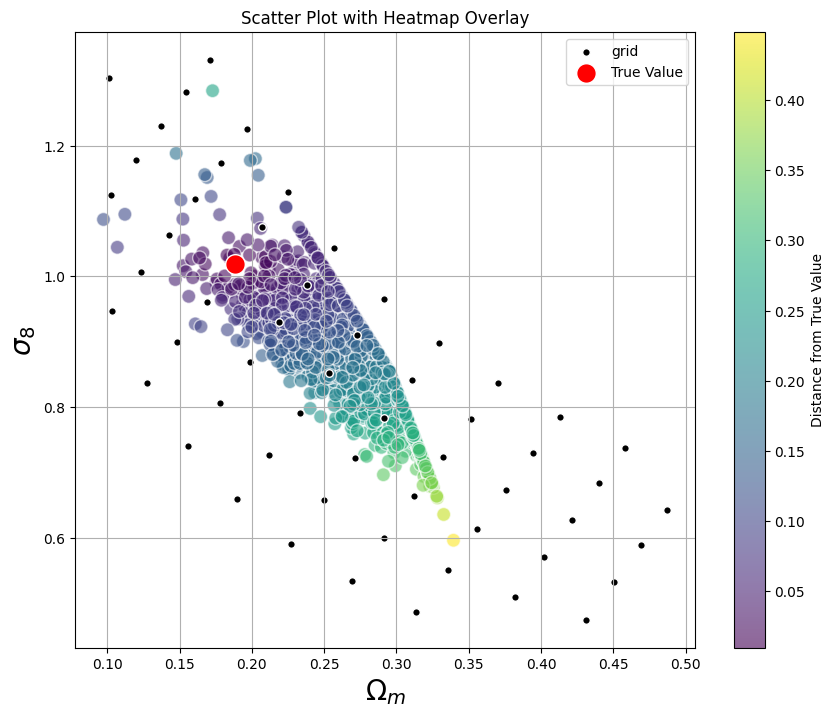

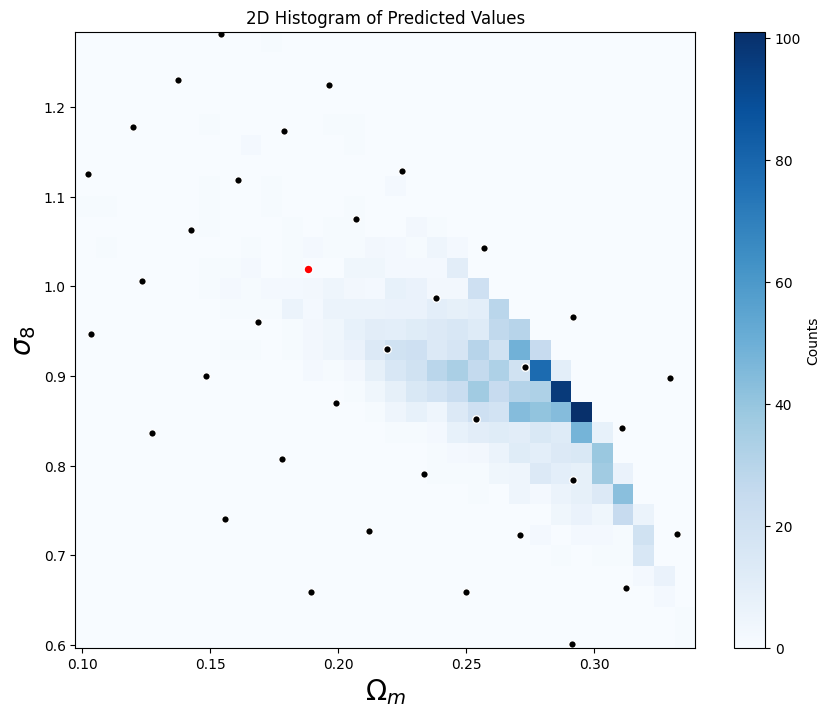

In [54]:
#in the test data every parameter is concurrent 2000 elements
#real epoch epoch * 5 if epoch == 1
epoch = 16
#start = 0
#stop = 2000
start, stop, file_index = start_stop(file_nr = 45)
print(start,stop)
pred_omega_m = pred_omega_m_list[epoch][start:stop]
pred_sigma_8 = pred_sigma_8_list[epoch][start:stop]
true_omega_m = true_omega_m_list[epoch][start:stop][0]
#print(true_omega_m_list[epoch])
true_sigma_8 = true_sigma_8_list[epoch][start:stop][0]

distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pred_omega_m, pred_sigma_8, c=distances, cmap='viridis', s=100, alpha=0.6, edgecolor='w')

# Add color bar to show the distance scale
cbar = plt.colorbar(scatter)
cbar.set_label('Distance from True Value')

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Plot the true value point
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=200, label='True Value', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 
#plt.xlim(0.05, 0.5)  # Adjust the limits according to your data
#plt.ylim(0.4, 1.4) 
plt.title('Scatter Plot with Heatmap Overlay')
plt.legend()
plt.grid(True)



# Show the plot
plt.show()

# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[30, 30], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')
#plt.xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
#plt.ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2) 


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')

# Show plot
plt.show()

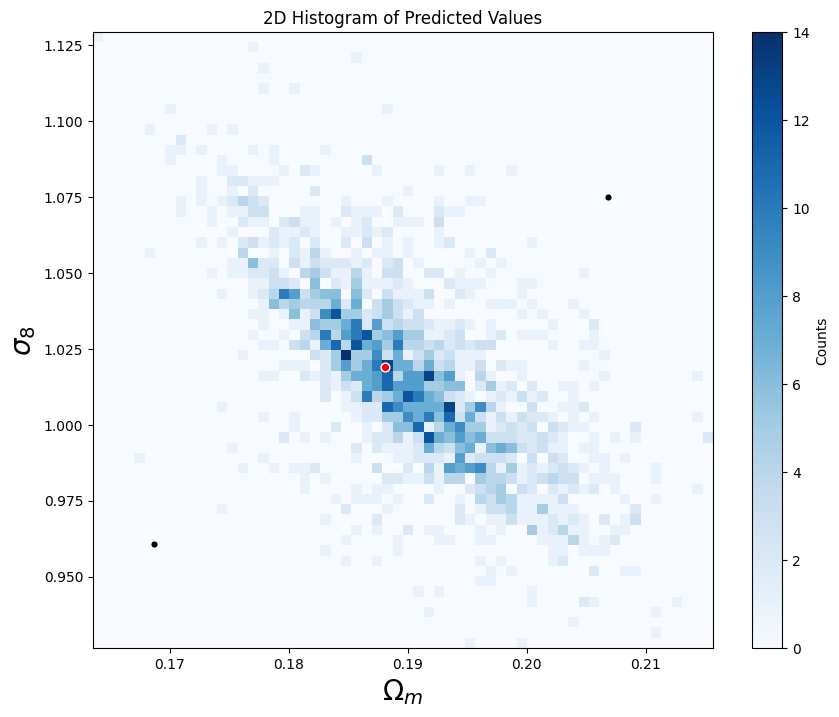

In [21]:
# Create 2D histogram
x = pred_omega_m
y = pred_sigma_8
plt.figure(figsize=(10, 8))
plt.cla()
plt.hist2d(x, y, bins=[60, 60], cmap='Blues')

# Add color bar to show scale
plt.colorbar(label='Counts')
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='grid', edgecolor='w')
plt.scatter(true_omega_m, true_sigma_8, c='red', s=40, label='True Value', edgecolor='w')

plt.xlabel(r'$\Omega_m$',fontsize = 20)
plt.ylabel(r'$\sigma_8$',fontsize = 20)

plt.title('2D Histogram of Predicted Values')


# Show plot
plt.show()

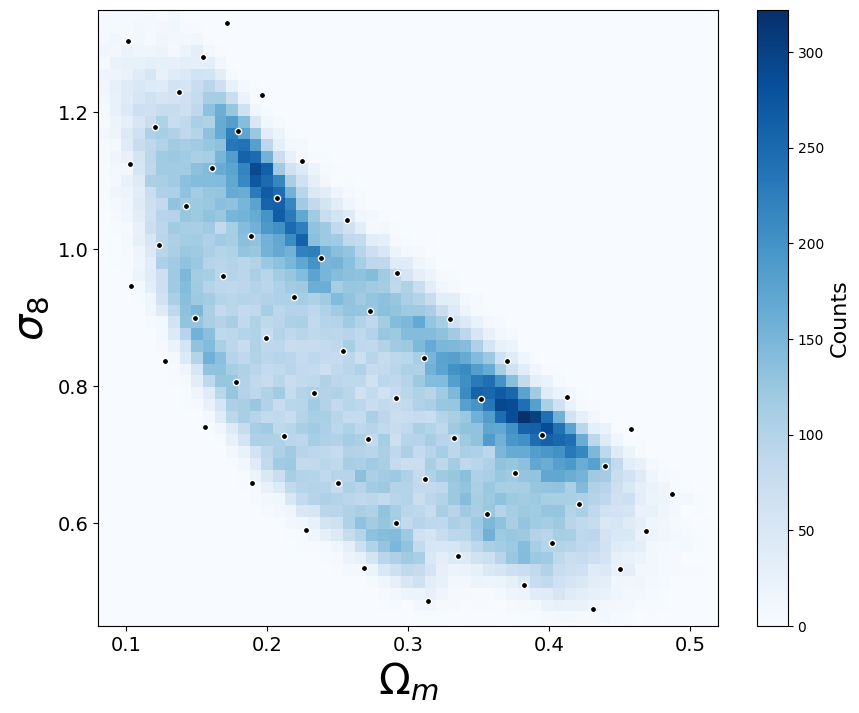

In [66]:
# Create 2D histogram
from matplotlib.ticker import MaxNLocator
x = pred_omega_m_list[epoch]
y = pred_sigma_8_list[epoch]
plt.figure(figsize=(10, 8))
plt.hist2d(x, y, bins=[60, 60], cmap='Blues') #cmap = Blues

# Add color bar to show scale
cbar = plt.colorbar(label='Counts')
cbar.set_label("Counts" ,fontsize = 16)
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=20, label='grid', edgecolor='w')

# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 30)
plt.ylabel(r'$\sigma_8$',fontsize = 30)


# Limit the number of ticks on both axes
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks on the x-axis
ax.yaxis.set_major_locator(MaxNLocator(5))  # 5 ticks on the y-axis

# Set the font size for the ticks
plt.tick_params(axis='both', which='major', labelsize=14)


#plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' means apply to both x and y axes, 'major' applies to major ticks

# Fix the x-axis limits
plt.xlim(0.08, 0.520)  # This sets the x-axis to range from 0 to 6
plt.ylim(0.45, 1.35)  # This sets the y-axis to range from 0 to 50



#plt.title('Predicted Values snapshot',fontsize = 20)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/final_plots_simclr_pres/" +run_name+"_paramsphist"

plt.savefig(save_path+'.pdf')
plt.savefig(save_path+'.png', dpi=300)

# Show plot
plt.show()

Processing files: 57it [00:06,  8.77it/s]


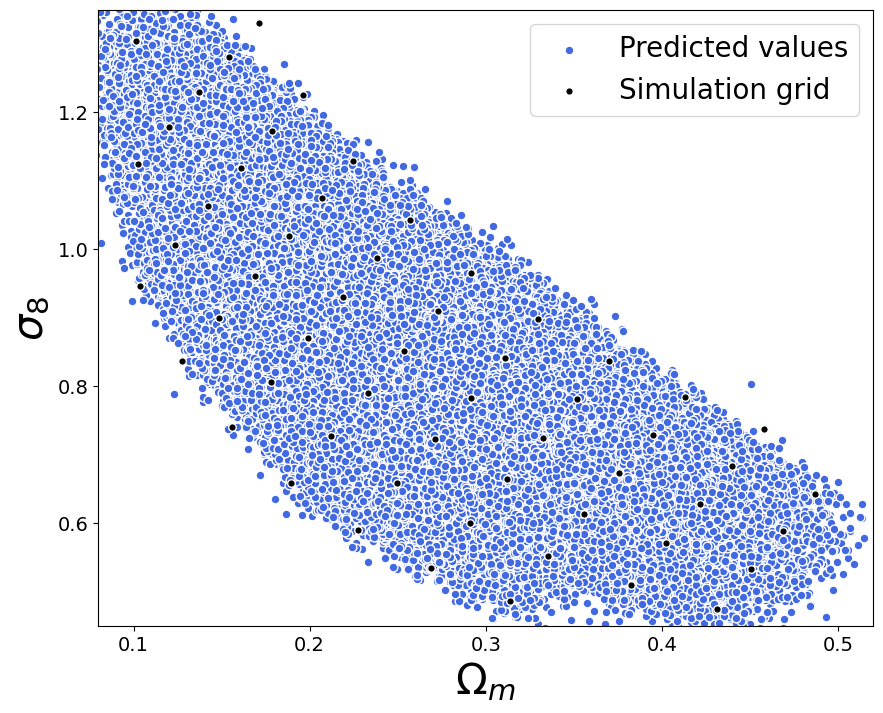

In [65]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


#in the test data every parameter is concurrent 2000 elements
#epoch = 1
pred_omega_m = pred_omega_m_list[epoch]
pred_sigma_8 = pred_sigma_8_list[epoch]


plt.figure(figsize=(10, 8))


truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Add color bar to show scale stock blue = "#4169E1"
plt.scatter(pred_omega_m, pred_sigma_8, c= "#4169E1", s=40, label='Predicted values',edgecolor= "w")
plt.scatter(grid_omega_m, grid_sigma_8, c='black', s=30, label='Simulation grid', edgecolor='w')


# Add labels and title
plt.xlabel(r'$\Omega_m$',fontsize = 30)
plt.ylabel(r'$\sigma_8$',fontsize = 30)

# Limit the number of ticks on both axes
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks on the x-axis
ax.yaxis.set_major_locator(MaxNLocator(5))  # 5 ticks on the y-axis

# Set the font size for the ticks
plt.tick_params(axis='both', which='major', labelsize=14)
#plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' means apply to both x and y axes, 'major' applies to major ticks

# Fix the x-axis limits
plt.xlim(0.08, 0.520)  # This sets the x-axis to range from 0 to 6
plt.ylim(0.45, 1.35)  # This sets the y-axis to range from 0 to 50
plt.legend(fontsize=20)



#plt.title('Predicted Values snapshot',fontsize = 20)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/final_plots_simclr_pres/" +run_name+"_scatter"
plt.savefig(save_path+'.png', dpi=300)
#plt.savefig(save_path+'.pdf'

# Show plot
plt.show()

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
#in the test data every parameter is concurrent 2000 elements
start, stop, file_index = start_stop(file_nr = 8)
# Sample data (replace this with your data)
parameter1_data =  pred_omega_m_list # Example data for parameter 1
parameter2_data =  pred_sigma_8_list# Example data for parameter 2
true_omega_m = true_omega_m_list[epoch][0]
true_sigma_8 = true_sigma_8_list[epoch][0]

truegrid_array = get_truegrid()
grid_omega_m = truegrid_array[:, 0]
grid_sigma_8 = truegrid_array[:, 1]

# Initialize the plot
fig, ax = plt.subplots()
plt.close()  # Prevents the empty plot from being displayed initially

# Function to update the scatter plot
def update(frame):
    pred_omega_m = parameter1_data[frame][start:stop]
    pred_sigma_8 = parameter2_data[frame][start:stop]
    true_omega_m = true_omega_m_list[frame][start:stop][0]
    true_sigma_8 = true_sigma_8_list[frame][start:stop][0]
    distances = np.sqrt((pred_omega_m - true_omega_m)**2 +(pred_sigma_8 - true_sigma_8)**2)
    
    #print(distances.shape)
    
    ax.clear()
    ax.set_xlim(true_omega_m - 0.2, true_omega_m + 0.2)  # Adjust the limits according to your data
    ax.set_ylim(true_sigma_8 - 0.2, true_sigma_8 + 0.2)  # Adjust the limits according to your data
    ax.set_title(f"Evolution of omega_m and sigma_8 with batch size: {batch_size}")
    ax.set_xlabel('Omega_m')
    ax.set_ylabel('sigma_8')
    
    
    # Plot scatter points for the current step
    sns.scatterplot(x=pred_omega_m, y=pred_sigma_8, hue = distances ,ax=ax)
    #sns.heatmap(distances, ax=ax, cmap="viridis", cbar=True, alpha=0.6, annot=True)
    sns.scatterplot(x=grid_omega_m, y=grid_sigma_8 , ax=ax, color="black", marker="o", s= 15)
    sns.scatterplot(x=true_omega_m_list[frame][start:stop], y=true_sigma_8_list[frame][start:stop] , ax=ax, color="red", marker="o", s= 30)
    
    ax.text(0.95, 0.05, f'Epoch: {frame * 5}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.text(0.65, 0.95,f'True: omega_m: {true_omega_m:.2f}, sigma_8: {true_sigma_8:.2f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(parameter1_data), interval=300)

# Save animation as MP4
#ani.save('animated_scatter.mp4', writer='ffmpeg')
plt.show()

# Alternatively, save as GIF (requires ImageMagick)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/plots/" +run_name
ani.save(save_path + "one_param_mse" + ".gif", writer='imagemagick')


Processing files: 57it [00:00, 485.20it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


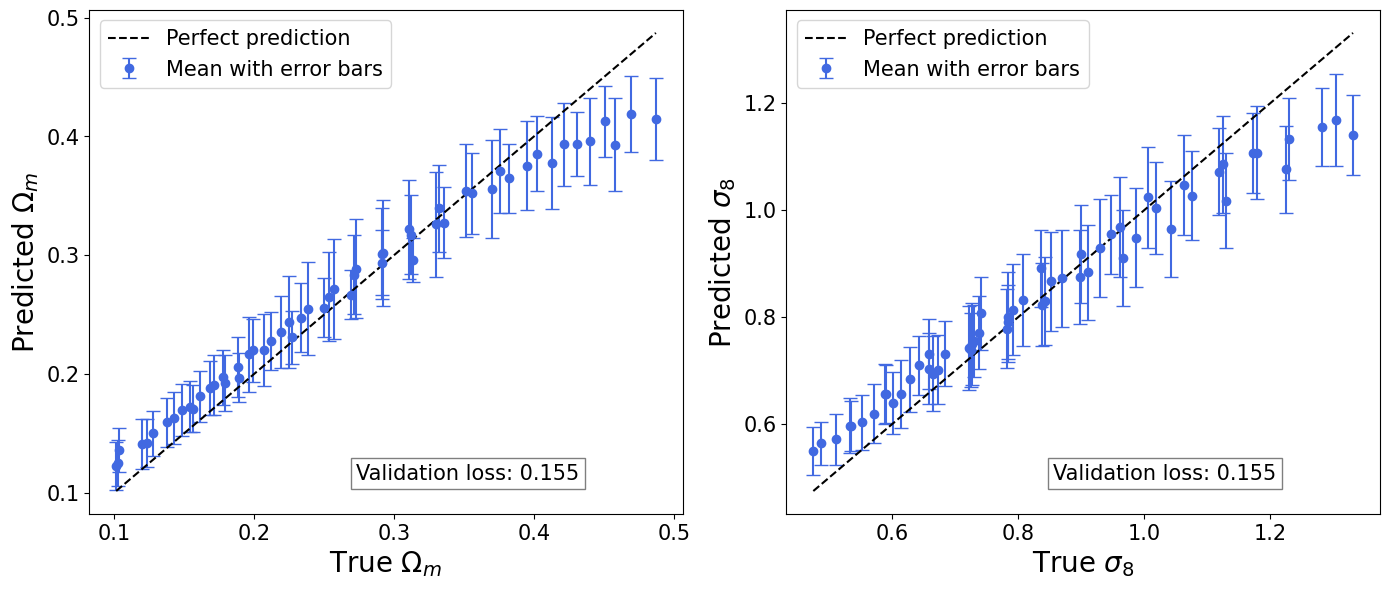

In [64]:
#### import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Generate random data for demonstration
np.random.seed(42)
true_omega_m_list_plot = true_omega_m_list[epoch]
pred_omega_m_list_plot = pred_omega_m_list[epoch]

true_sigma_8_list_plot = true_sigma_8_list[epoch]
pred_sigma_8_list_plot = pred_sigma_8_list[epoch]

# Function to plot true vs predicted values with error bars
def plot_with_error_bars(true_values, pred_values, parameter_name, ax):
    # Calculate unique true values, their mean predicted values, and standard deviation
    unique_true_values = np.unique(true_values)
    mean_pred_values = [np.mean(pred_values[true_values == val]) for val in unique_true_values]
    std_pred_values = [np.std(pred_values[true_values == val]) for val in unique_true_values]
    
    # Scatter plot of the true vs predicted values
    #ax.scatter(true_values, pred_values, label='Data points', alpha=0.6)
    
    # Plotting the mean with error bars blue = "#4169E1"
    ax.errorbar(unique_true_values, mean_pred_values, yerr=std_pred_values, fmt='o', color="#4169E1", label='Mean with error bars', capsize=5)

    # Diagonal line (perfect prediction)
    ax.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', label='Perfect prediction')

    
    ax.set_xlabel(f'True {parameter_name}',fontsize = 20)
    ax.set_ylabel(f'Predicted {parameter_name}',fontsize = 20)

    # Set tick spacing and font size
    tick_fontsize = 15
    max_ticks = 5
    ax.xaxis.set_major_locator(MaxNLocator(max_ticks))  # Integer ticks on x-axis
    ax.yaxis.set_major_locator(MaxNLocator(max_ticks))  # Integer ticks on y-axis
    ax.xaxis.set_tick_params(labelsize=tick_fontsize)
    ax.yaxis.set_tick_params(labelsize=tick_fontsize)

    validation_loss = 0.155
    ax.text(0.45, 0.1, f'Validation loss: {validation_loss:.3f}', 
                transform=ax.transAxes, fontsize=15, verticalalignment='top', 
                bbox=dict(facecolor='white', alpha=0.5))
    
    #ax.set_title(f'True vs Predicted {parameter_name}')
    ax.legend(fontsize=15)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for omega_m
plot_with_error_bars(true_omega_m_list_plot, pred_omega_m_list_plot, '$\Omega_m$', axs[0])

# Plot for sigma_8
plot_with_error_bars(true_sigma_8_list_plot, pred_sigma_8_list_plot, '$\sigma_8$', axs[1])
#plt.title('Predicted Values snapshot',fontsize = 20)
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/final_plots_simclr_pres/" +run_name+"_perdictedtrue"

plt.savefig(save_path+'.pdf')
plt.savefig(save_path+'.png', dpi=300)

plt.tight_layout()
plt.show()

Show simclr positive pair

In [2]:
import numpy as np
import torch
import yaml
import torch.nn as nn
from torchvision import transforms
import numpy as np
import time, os, random
import pickle
from torchsummary import summary
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader



from my_utils.simclr_loader import Kids450, kids450_files_cluster
from my_utils.NT_xent_loss import SimCLR_Loss
from my_utils.real_resnets import Resnet_pretrainingmodel
from my_utils.models import custom_pretrainingmodel, custom_DSModel, custom_Regression_model
from my_utils.simclr_collate import collate_fn
from my_utils.LARS import LARS
import yaml

In [25]:
file_paths_train, file_paths_test = kids450_files_cluster()
batch_size = 192
resolution = 128
train_data = Kids450(phase = "train",file_paths = file_paths_train,resolution = resolution)
#valid_data = regr_Kids450(phase = "val",file_paths = file_paths_train,resolution = resolution)
#test_data =  regr_Kids450(phase = "test",file_paths = file_paths_test,resolution = resolution)
kids_train_loader = DataLoader(train_data,batch_size = batch_size , drop_last=True,collate_fn = collate_fn, num_workers = 60)
#kids_valid_loader = DataLoader(valid_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)
#kids_test_loader = DataLoader(test_data,batch_size = batch_size , drop_last=True,collate_fn = cosmotrain_collate_fn, num_workers = 60)
dataiter = iter(kids_train_loader)

In [26]:
xis,xjs = next(dataiter)
x_i,x_j = xis[0],xjs[0]

In [20]:
x_i.shape

torch.Size([1, 4, 128, 128])

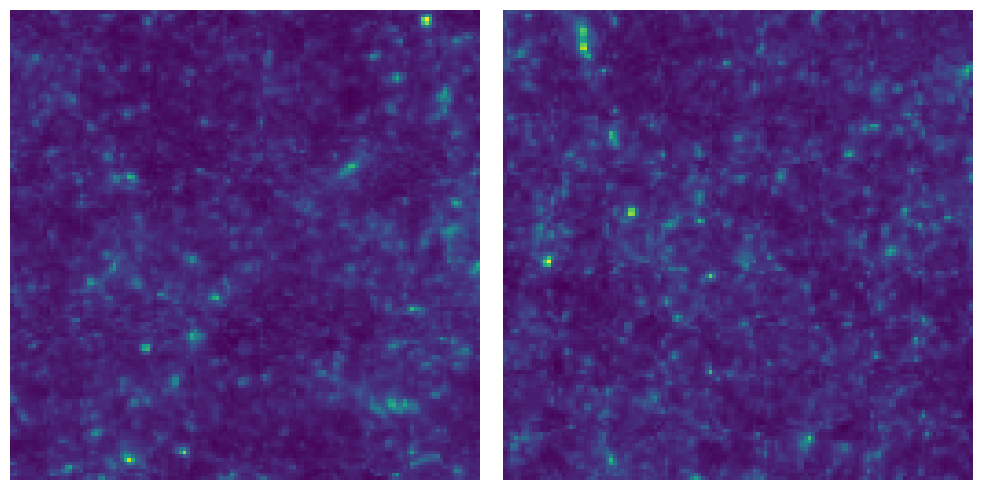

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Load or create dummy 4-channel tomographic images
# Replace these with your actual image data
image1 = x_i.squeeze()
image2 = x_j.squeeze()

# Extract the 1st channel from both images
channel1_image1 = image1[0,:, :]
channel1_image2 = image2[0,:, :]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first channel of the first image
axes[0].imshow(channel1_image1, cmap='viridis')
#axes[0].set_title('Image 1 - 1st Channel')
axes[0].axis('off')  # Hide the axes

# Plot the first channel of the second image
axes[1].imshow(channel1_image2, cmap='viridis')
#axes[1].set_title('Image 2 - 1st Channel')
axes[1].axis('off')  # Hide the axes

# Save the figure as a PNG file
save_name = "x_i_x_j_examp"
plt.savefig(save_name+".png", format='png')

# Save the figure as a PDF file
plt.savefig(save_name+".pdf", format='pdf')

# Show the plots
plt.tight_layout()
plt.show()


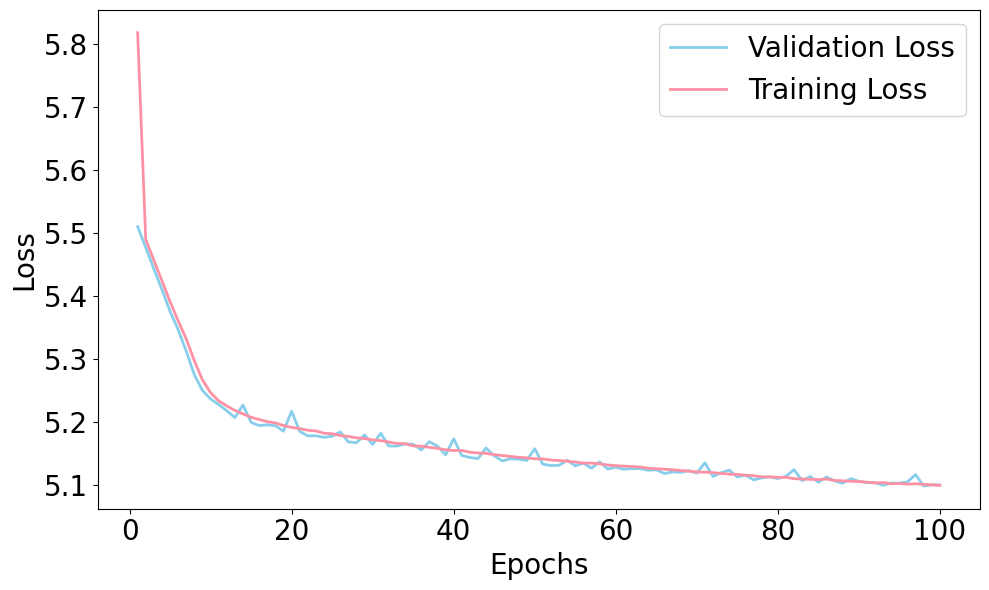

In [13]:
#loss curve for pretraining https://wandb.ai/atepper/simclr_pretraining/runs/9yiq87vn?nw=nwuseraaditep
#cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/pretraining_resnet34.csv
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('./data/pretraining_resnet34.csv')

# Extract the columns
epochs = data['epoch']
val_loss = data['val_loss']
train_loss = data['train_loss']

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting the losses
plt.plot(epochs, val_loss, label='Validation Loss', color="#87CEEB", linestyle='-', linewidth=2)
plt.plot(epochs, train_loss, label='Training Loss', color='#FF91A4', linestyle='-', linewidth=2)

# Customize fonts and tick sizes
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add legend
legend = plt.legend(fontsize=20, loc='upper right')
frame = legend.get_frame()
frame.set_facecolor('white')  # Customizing legend background color
run_name = "resnet34_pretrain"
save_path = "/cluster/home/atepper/master_thesis/master_thesis/Full_simclr/data/final_plots_simclr/" +run_name+"_loss"

plt.savefig(save_path+'.pdf')
plt.savefig(save_path+'.png', dpi=300)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()